## Preprocessing

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score

C:\Users\knyag\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open(r'C:\Users\knyag\Downloads\Beatup\Beatup\dataset_numeric_full.pkl.txt', 'rb') as f:
    data = pickle.load(f)

In [3]:
file = pd.DataFrame(data)

In [4]:
ids = file.id1.unique()
IDN = ids.shape[0]

In [5]:
file['date'] = pd.to_datetime(file.date, dayfirst = True)

In [5]:
file['id12'] = file[['id1', 'id2']].min(axis=1).apply(str)+'_'+file[['id1', 'id2']].max(axis=1).apply(str)

In [6]:
file['order'] = file['dsf_vector'].apply(lambda x: len(x))

In [7]:
file.sort_values(by = ['id12','order'], inplace = True)

In [8]:
file = file.iloc[::2]

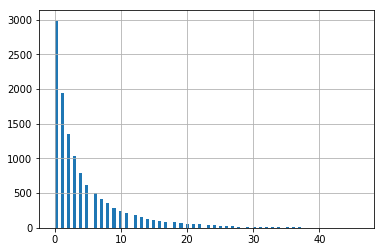

In [219]:
file.order.hist(bins = 100)

In [241]:
file.order.quantile(0.99)

27.0

In [252]:
file[file.order >= 40].shape[0]

7

In [9]:
def vectors_to_matrix(name, pad = 0):
    
    temp = file[['id12',name,name+'_vector','order']].values
    x = []
    for i in range(1,temp.shape[0]):
        if temp[i,3] == 0:
            if temp[i-1,2] == []:
                x.append([temp[i-1,1]])
            else:
                x.append(temp[i-1,2][-1]+[temp[i-1,1]])
                
    if temp[-1,2] == []:            
        x.append([temp[-1,1]])
    else:
        x.append(temp[-1,2][-1]+[temp[-1,1]])
    
    for i in range(len(x)):
        x[i] = x[i] + [pad for j in range(max(map(len, x)) - len(x[i]))]
        
    return np.array(x).astype(float)

In [10]:
y = vectors_to_matrix('dsf')

In [11]:
ys = np.copy(y)
ys[ys == 1] = 0.2
ys[ys == -1] = -0.2
ys[ys == 2] = 0.6
ys[ys == -2] = -0.6
ys[ys == 3] = 1
ys[ys == -3] = -1

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [13]:
ratings = StandardScaler().fit_transform(vectors_to_matrix('current_rating1') - vectors_to_matrix('current_rating2'))

In [14]:
t = MinMaxScaler().fit_transform(vectors_to_matrix('ttligapro_liga_rating_min'))

In [15]:
from sklearn.preprocessing import OneHotEncoder as enc

In [16]:
p = np.vstack((file[file.order == 0]['id1'].values, file[file.order == 0]['id2'].values)).reshape(-1,1)
p = enc().fit_transform(p).toarray()
dp = p[:file[file.order == 0].shape[0],:] - p[file[file.order == 0].shape[0]:,:]

In [17]:
x = np.hstack((dp,ratings,t))
y_train, y_test, x_train, x_test = train_test_split(y, x, test_size = 0.2, random_state=42)

In [18]:
dp_train = x_train[:,:dp.shape[1]]
ratings_train = x_train[:,dp.shape[1]:dp.shape[1]+ratings.shape[1]]
t_train = x_train[:,dp.shape[1]+ratings.shape[1]:]
dp_test = x_test[:,:dp.shape[1]]
ratings_test = x_test[:,dp.shape[1]:dp.shape[1]+ratings.shape[1]]
t_test = x_test[:,dp.shape[1]+ratings.shape[1]:]

In [62]:
y_test.shape

(597, 47)

## Model

In [19]:
import tensorflow as tf
import keras as K
from keras.layers import Dense

C:\Users\knyag\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
K.backend.clear_session()
tf.reset_default_graph()
s = K.backend.get_session()

In [46]:
W = tf.get_variable(name = "W", shape = [IDN, 1], dtype = tf.float32)
B = tf.get_variable(name = "B", shape = [3, 7], dtype = tf.float32)
b = tf.get_variable(name = "b", shape = [1, 7], dtype = tf.float32)
P = tf.placeholder('float32', [None, IDN])
Y = tf.placeholder('float32', [None, None])
R = tf.placeholder('float32', [None, None])
T = tf.placeholder('float32', [None, None])
check = tf.expand_dims(Y, axis = 2)

In [47]:
c0 = h0 = P @ W

In [48]:
lstm = tf.nn.rnn_cell.LSTMCell(1)
hidden_states, _ = tf.nn.dynamic_rnn(lstm, check, initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

In [49]:
flat_hidden_states = tf.reshape(hidden_states,[-1, 1])
flat_R = tf.reshape(R,[-1, 1])
flat_T = tf.reshape(T,[-1, 1])
flat_Y = tf.cast(tf.reshape(Y,[-1]) , tf.int32)
flat_loss_mask = tf.not_equal(flat_Y, tf.zeros_like(flat_Y)+3)

In [50]:
X = tf.concat([flat_hidden_states, flat_R, flat_T], axis = 1)
results = X @ B + b

In [58]:
L = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=flat_Y, logits=results)
loss = tf.reduce_mean(tf.boolean_mask(L, flat_loss_mask))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
train_step = optimizer.minimize(loss)
masked_Y = tf.boolean_mask(flat_Y, flat_loss_mask)
masked_pred = tf.boolean_mask(tf.argmax(results, 1), flat_loss_mask)                              
acc, acc_op = tf.metrics.accuracy(labels=masked_Y, predictions=masked_pred)

C:\Users\knyag\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training

In [52]:
def generate_batch(y, p, r, t, batch_size):
    batch = np.random.choice(np.arange(y.shape[0]),batch_size,replace = False)
    batch_y = np.empty((batch_size, y.shape[1]))
    batch_p = np.empty((batch_size, p.shape[1]))
    batch_r = np.empty((batch_size, r.shape[1]))
    batch_t = np.empty((batch_size, t.shape[1]))
    for i,j in enumerate(batch):
        batch_y[i,:] = y[j,:]+3
        batch_p[i,:] = p[j,:]
        batch_r[i,:] = r[j,:]
        batch_t[i,:] = t[j,:]
    return {Y: batch_y, P: batch_p, R: batch_r, T: batch_t}

In [56]:
batch_size = 64
n_epochs = 20
n_batches_per_epoch = 2000
n_validation_batches = 400

In [54]:
from tqdm import tqdm_notebook as tqdm
import random

In [59]:
s.run(tf.global_variables_initializer())
s.run(tf.local_variables_initializer())
np.random.seed(42)
random.seed(42)

#history = []

for epoch in range(n_epochs):
    
    train_loss = 0
    counter = 0
    pbar = tqdm(range(n_batches_per_epoch))
    for _ in pbar:
        train_loss += s.run([loss, train_step], generate_batch(y_train, dp_train, ratings_train, t_train, batch_size))[0]
        counter += 1
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(loss, generate_batch(y_test, dp_test, ratings_test, t_test, batch_size))
        
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    accuracy = s.run(acc, feed_dict = generate_batch(y_test, dp_test, ratings_test, t_test, batch_size))
    print('Accuracy: '+str(accuracy))
    
    '''history.append(val_loss)
    
    clear_output(True)
    plt.plot(history, label='validation loss')
    plt.legend()
    plt.show()'''

    
print("Finished!")

Epoch: 0, train loss: 1.8011662799715995, val loss: 1.5104089456796645
Accuracy: 0.0


Epoch: 1, train loss: 1.3271428892612458, val loss: 1.2032385402917862
Accuracy: 0.0


Epoch: 2, train loss: 1.1445346397161484, val loss: 1.1121990177035332
Accuracy: 0.0


Epoch: 3, train loss: 1.0613682912290097, val loss: 1.0121259114146233
Accuracy: 0.0


Epoch: 4, train loss: 0.9540535660982132, val loss: 0.9206483823060989
Accuracy: 0.0


Epoch: 5, train loss: 0.8808428225815296, val loss: 0.8632829856872558
Accuracy: 0.0


Epoch: 6, train loss: 0.8330584278404712, val loss: 0.8230304761230945
Accuracy: 0.0


Epoch: 7, train loss: 0.798004733979702, val loss: 0.7943518115580082
Accuracy: 0.0


Epoch: 8, train loss: 0.7709357681572437, val loss: 0.7730061426758766
Accuracy: 0.0


Epoch: 9, train loss: 0.7484572911560535, val loss: 0.7552535770833493
Accuracy: 0.0


Epoch: 10, train loss: 0.7295774747729301, val loss: 0.7372084671258926
Accuracy: 0.0


Epoch: 11, train loss: 0.7118799575269222, val loss: 0.7155162179470063
Accuracy: 0.0


Epoch: 12, train loss: 0.6966070536077023, val loss: 0.6944802804291248
Accuracy: 0.0


Epoch: 13, train loss: 0.682028436511755, val loss: 0.6817202255129814
Accuracy: 0.0


Epoch: 14, train loss: 0.6691107560098172, val loss: 0.6679444389045238
Accuracy: 0.0


Epoch: 15, train loss: 0.6564252242743969, val loss: 0.6578613689541817
Accuracy: 0.0


Epoch: 16, train loss: 0.6449667122066021, val loss: 0.6480595636367797
Accuracy: 0.0


Epoch: 17, train loss: 0.6341190542280674, val loss: 0.6392565336823464
Accuracy: 0.0


Epoch: 18, train loss: 0.624147227793932, val loss: 0.6380221118032933
Accuracy: 0.0


Epoch: 19, train loss: 0.6142208555638791, val loss: 0.6334330803155899
Accuracy: 0.0
Finished!


In [60]:
saver = tf.train.Saver()
saver.save(s, r'C:\Users\knyag\Downloads\Beatup\Beatup\model_3', global_step=epoch)

'C:\\Users\\knyag\\Downloads\\Beatup\\Beatup\\model_3-19'